<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe61622](https://jckantor.github.io/cbe61622);
content is available [on Github](https://github.com/jckantor/cbe61622.git).*


<!--NAVIGATION-->
< [10.10 Computer Vision Case Study: Introduction](https://jckantor.github.io/cbe61622/10.10-Computer-Vision-Introduction.html) | [Contents](toc.html) | [10.12 Computer Vision Case Study: Creating an Application](https://jckantor.github.io/cbe61622/10.12-Computer-Vision-Application.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe61622/blob/master/docs/10.11-Computer-Vision-Development.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe61622/10.11-Computer-Vision-Development.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 10.11 Computer Vision Case Study: Finding Particles in Images

## 10.11.1 Developing a Process

Our approach ...

* Read image
* Crop
* Separate into channels
* Creat a composite
* Equalize histogram
* Blur/Low Pass Filter
* Segment/Threshold
* Use Morphology Transforms to isolate objects
* Locate Objects - Blobs vs Hough Transforms
* Prepare a Report
* Encapsulate as a Python Class

### 10.11.1.1 Python Imports

We track overall code dependencies by consolidating imports into this cell. Note that we'll be using elements from multiple packages by relying on the underlying NumPy representation of images to hold the current state of the process.

In [3]:
%matplotlib inline

# standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

# computer vision libraries
import cv2 as cv2

### 10.11.1.2 Reading images

As a first step, read the image, convert to rgb scale, and display. All of these packages have a means of reading raster file images in common formats. There are small (and sometimes frustrating) differences among them. Here we use the Matplotlib ``imread()`` method which reads and returns a numpy array.

The array will typical have 2 or 3 dimensions $(h, w, d)$ where $h$ and $w$ are image height and width, and $d$ is pixel depth.

* If $d$ is one or not present, it is a gray scale image
* If $d$ is 3, then typically it is an RGB image with the channels repesenting R, G, and B colors. Note that OpenCV orders the channels as BGR.
* If $d$ is 4, the image could be RGBA where A refers to an alpha transparency channel, or a CYMK encoded color image.

In [4]:
filepath = "data/25-miniM.tif"

# read color image with OpenCV
img_bgr = cv2.imread(filepath)
print(img_bgr.shape)

(2048, 2560, 3)


Text(0.5, 1.0, 'A BGR image incorrectly shown as RGB')

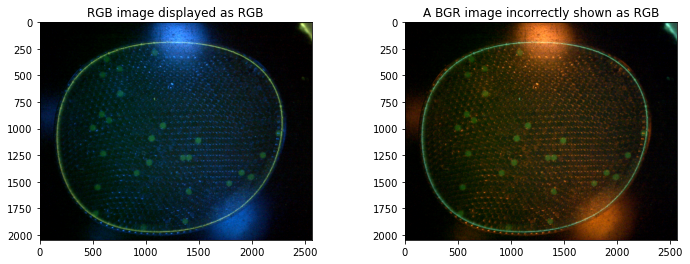

In [5]:
# convert to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# display images with Matploblib
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].imshow(img_rgb)
ax[0].set_title("RGB image displayed as RGB")

ax[1].imshow(img_bgr)
ax[1].set_title("A BGR image incorrectly shown as RGB")

Observations:
* The full color image shows diffuse and specular reflections of the blue led used to excite the flourophores.
* The flourescence signal is largelyl confined to the green channel
* There are extraneous elements at the edges of the image

### 10.11.1.3 Cropping

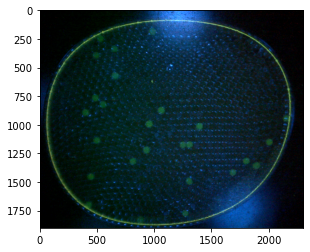

In [6]:
img = img_rgb[100:2000, 100:2400, :].copy()
plt.imshow(img)

### 10.11.1.4 Channels and Histograms

An image is comprised of one or more channels

* Each channel can be treated as a gray scale image
* The values at each pixel may be
    * An 8-bit unsigned integer in the range 0 to 255 (most common)
    * A 12, 14, or 16 bit unsigned integer
    * A real number between 0 and 1
* Color must always be interpreted with respect to [color space](https://en.wikipedia.org/wiki/Color_space).
    


In [7]:
r, g, b = cv2.split(img)

Histograms are a tool for analyzing the distribution of gray levels in a channel. It's a powerful tool for controlling exposure and processing images for presentation.

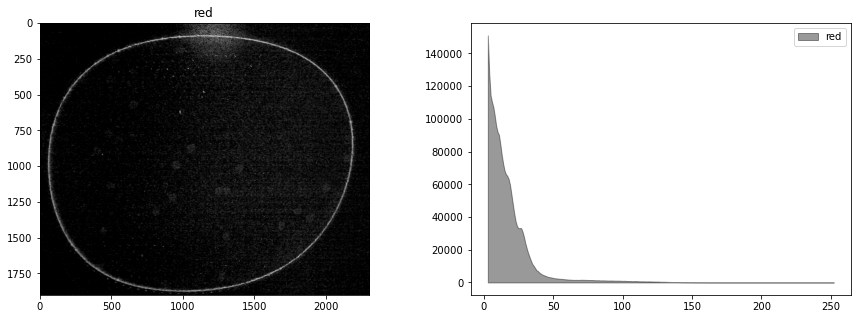

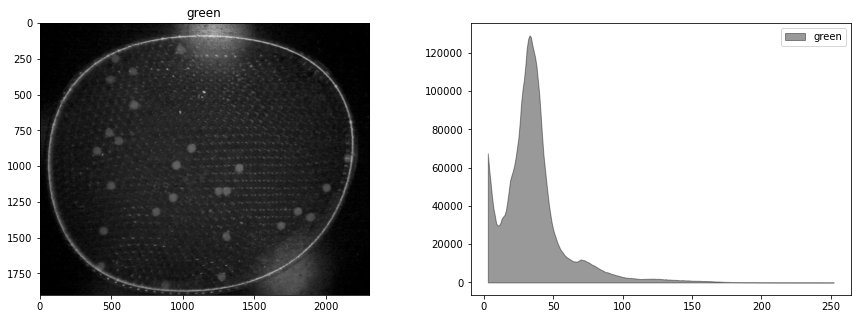

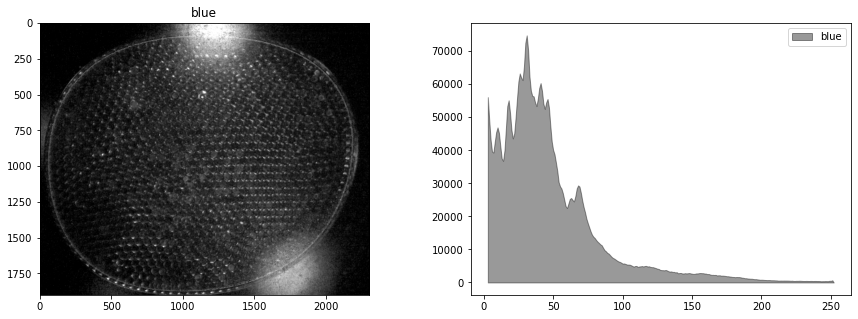

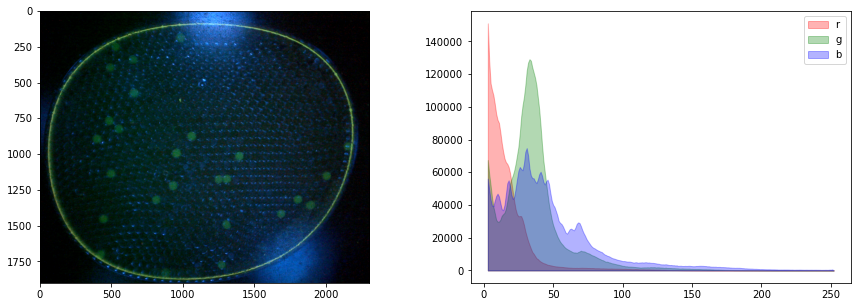

In [8]:
def histogram(channel, bp=3, wp=252):
    """Return histogram and bins for a single channel."""
    hist = cv2.calcHist([channel], [0], None, [wp-bp+1], [bp, wp])
    bins = np.array([b for b in range(bp, wp+1)])
    return hist.flatten(), bins

def display_channel(channel, label=""):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(channel.astype(np.uint8), cmap="gray")
    ax[0].set_title(label)
    hist, bins = histogram(channel.astype(np.uint8))
    ax[1].fill_between(bins, hist, alpha=0.4, color="k", label=label)
    ax[1].legend()

display_channel(r, "red")
display_channel(g, "green")
display_channel(b, "blue")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img)
for color, channel in zip(['r', 'g', 'b'], [r, g, b]):
    hist, bins = histogram(channel)
    ax[1].fill_between(bins, hist, color=color, label=color, alpha=0.3)
ax[1].legend()

### 10.11.1.5 Creating a composite channel

We see the blue leds used to excite the flourophores bleed over into the green channel. It would be best if this could be corrected in the experiment, perhaps by positioning a bandpass filter in front of the leds. What we will attempt here is subtract a multiple of blue channel from the green channel, followed by exposure adjustments. The goal is to provide a cleaner image for doing particle labeling and counting. 

By trial and error, we find a weighted difference of the green and blue channels, and a rescaling of the tone curve that retains the particles and reduces background interference.

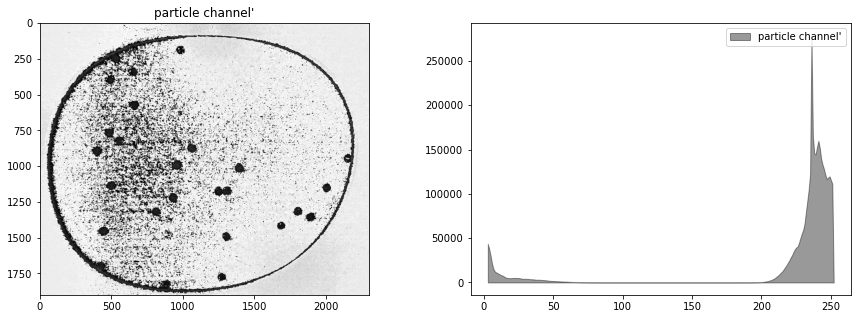

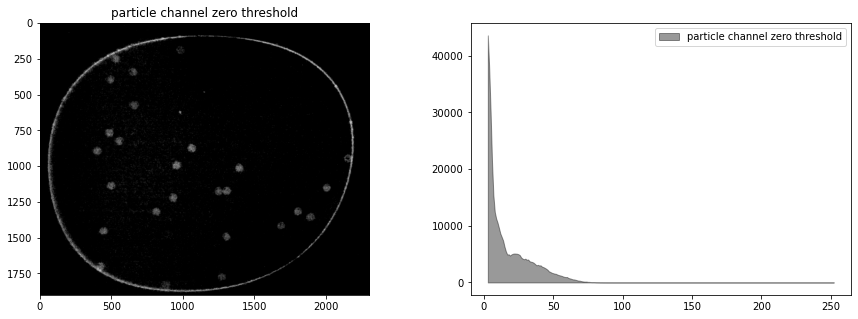

In [9]:
# subtract blue channel from green channel
blue_weight = 0.58
offset = -20
cimg = (g - blue_weight*b - .2*r) + offset

# display composite channel
display_channel(cimg, "particle channel'")

# set zero threshold and convert to integer
cimg = np.where(cimg < 0, 0, cimg)
cimg = cimg.astype(np.uint8)
display_channel(cimg, "particle channel zero threshold")

### 10.11.1.6 Histogram equalization

At this stage our composite image appears significantly underexposed. Looking at just the green channel, increasing the exposure 4x, or even 6x, would significantly brighten the particles that we're seeking to detect. In future versions of the experiment it may be useful to experiment with signficantly brighter lenses, light sources, or longer exposures.

In the meanwhile, the step in image processing is to equalize the histogram to improve opportunities for effective particle detection.

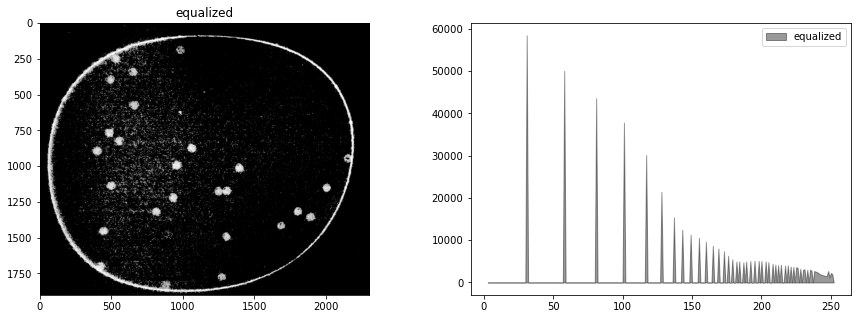

In [10]:
himg = cv2.equalizeHist(cimg)
display_channel(himg, 'equalized')

Observations

* Quantization (sometimes seen as banding) caused by limited number of levels in the channel.
* The image was underexposed at the time of capture.

### 10.11.1.7 Blur filter


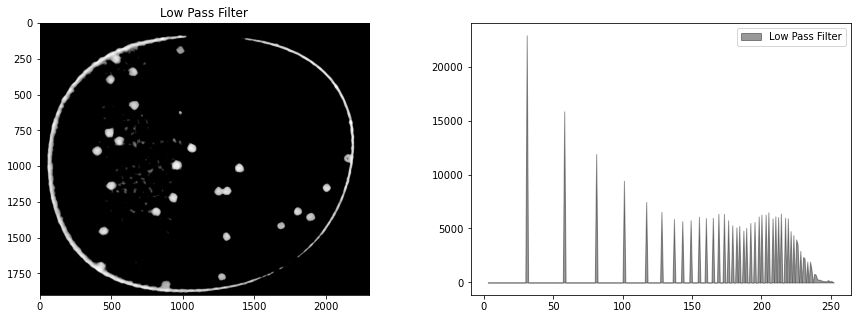

In [11]:
# kernel size (odd number)
ksize = 21

# median filter
bimg = cv2.medianBlur(himg, ksize)
display_channel(bimg, "Low Pass Filter")

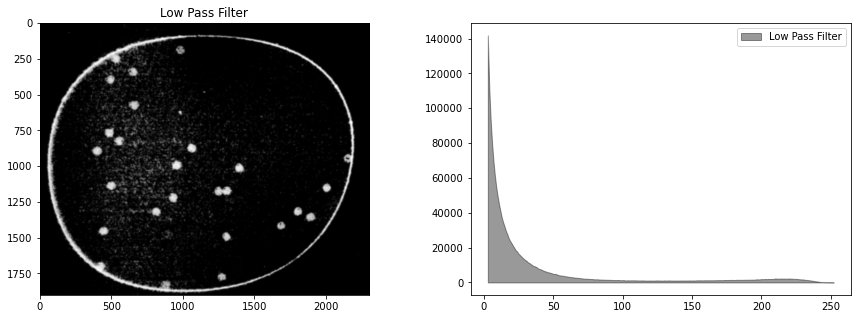

In [12]:
# Gaussian filter
bimg = cv2.GaussianBlur(himg, (ksize, ksize), 0)
display_channel(bimg, "Low Pass Filter")

### 10.11.1.8 Thresholding/Segmentation

The purpose of threshold is to isolate the features of interest from background noise. 

https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html

Threshold = 89.0


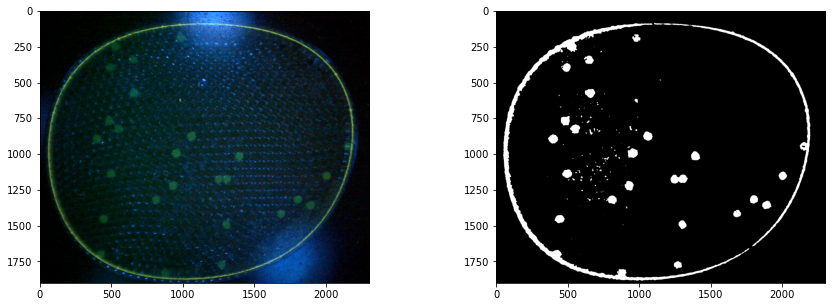

In [13]:
threshold = 130

T, simg = cv2.threshold(bimg, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(simg, cmap="gray")
print(f"Threshold = {T}")

### 10.11.1.9 Morphological Transformation

The next goal is to remove noise and to separate particles.

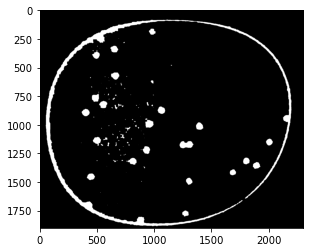

In [17]:
kernel = np.ones((3, 3))
iterations = 8

def morph_close (img, kernel, iterations=1):
    ret = cv2.dilate(img, kernel=kernel, iterations=iterations)
    ret = cv2.erode(ret, kernel=kernel, iterations=iterations)
    return ret

close_img = morph_close(simg, kernel, iterations)
plt.imshow(close_img, cmap="gray")

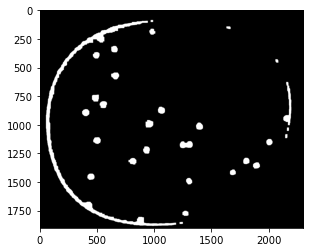

In [18]:
kernel = np.ones((3, 3))
iterations = 8

def morph_open(img, kernel, iterations):
    ret = cv2.erode(img, kernel=kernel, iterations=iterations)
    ret = cv2.dilate(ret, kernel=kernel, iterations=iterations)
    return ret

open_img = morph_open(close_img, kernel, iterations)

plt.imshow(open_img, cmap="gray")

### 10.11.1.10 Finding Objects

http://pageperso.lif.univ-mrs.fr/~francois.denis/IAAM1/scipy-html-1.0.0/tutorial/ndimage.html

Text(0.5, 1.0, '29 particles labeled')

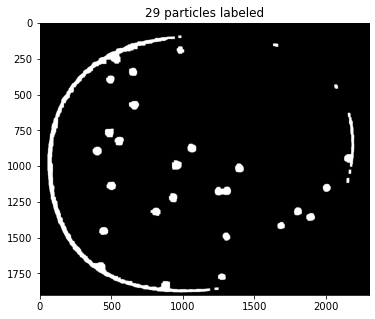

In [19]:
# find particles and plot objects
structure = np.ones((3, 3))
label_img, particle_count = ndimage.measurements.label(open_img, structure=structure)

# pixels are labeled with numbers corresponding to objects
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.imshow(np.where(label_img > 0, 1, np.zeros(label_img.shape)), cmap="gray")
ax.set_title(f"{particle_count} particles labeled")

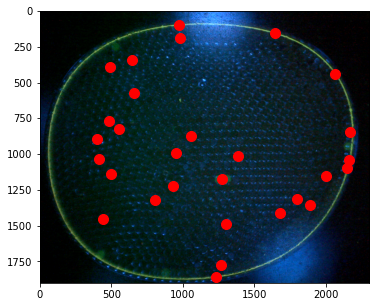

In [20]:
# centers of mass
pts = ndimage.center_of_mass(open_img, label_img, np.arange(1, particle_count + 1))

x = [x for (y,x) in pts]
y = [y for (y,x) in pts]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.imshow(img)
ax.plot(x, y, '.', ms=20, color='r')

### 10.11.1.11 Finding and Displaying Particles

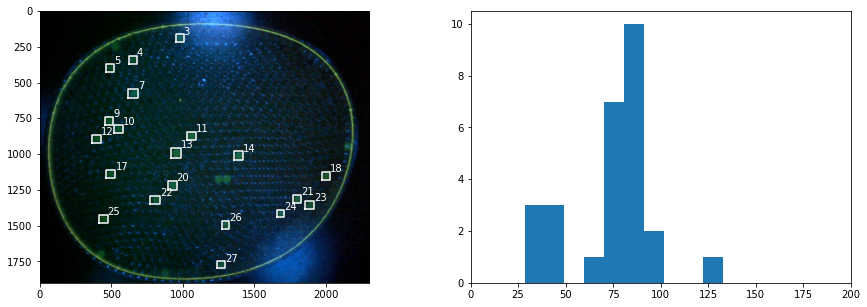

In [23]:
# find the objects and place bounding boxes
slices = ndimage.find_objects(label_img)
sizes = [np.sqrt((b.stop-b.start)**2 + (a.stop-a.start)**2) for a,b in slices]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[1].hist(sizes, bins=200)
ax[1].set_xlim(0, 200)
ax[0].imshow(img)
for k,size in enumerate(sizes):
    if size > 50 and size < 100:
        a,b = slices[k]
        ya = a.start
        yb = a.stop
        xa = b.start
        xb = b.stop
        ax[0].plot([xa, xb, xb, xa, xa], [yb, yb, ya, ya, yb], 'w')
        ax[0].text(xb, ya, f"{k}", color="w")

### 10.11.1.12 Creating a Training Set

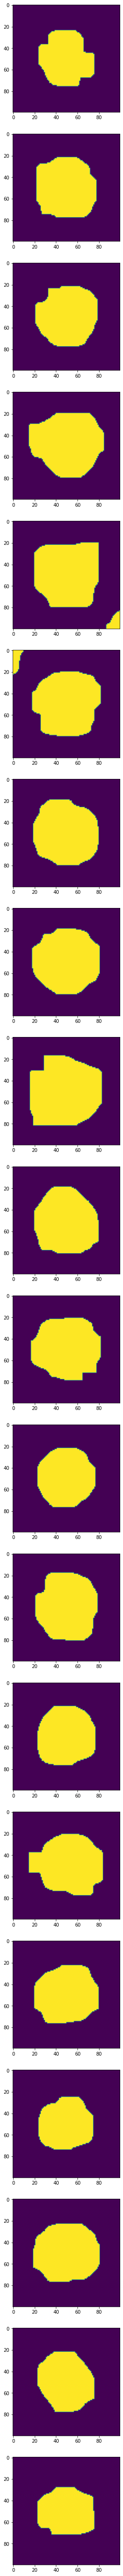

In [25]:
kdx = [k for k, size in enumerate(sizes) if size > 50 and size < 100]

dx = 100
dy = 100

def round_slice(s, n):
    """Round up slice to be width n"""
    m = s.stop - s.start
    start = s.start - int((n - m)/2)
    stop = start + n
    return slice(start, stop, 1)

fig, ax = plt.subplots(len(kdx), 1, figsize=(5, 5*len(kdx)))
for i, k in enumerate(kdx):
    a, b = slices[k]
    ax[i].imshow(open_img[round_slice(a, 100), round_slice(b, 100)])

### 10.11.1.13 What did we learn about our application?

* Improved Image Capture
    * Reduce glare from the blue leds
    * Increase exposure
    
* Image Processing Steps
    * read image
    * 
    * separate channels
    * combine channels to isolate green flourescent particles (weights?)
    * median filtering (size?)
    * histogram equalization
    * threshold (threshold value?)
    * morphological opening (kernal?, iterations?)
    * labeling (size?)
    

## 10.11.2 Particle Labeling Classes

To facilitate embedded use in a device, the next step is to consolidate these procedures into a class.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import ndimage


class Channel():
    
    def __init__(self, data):
        self.data = data
    
    @property
    def histogram(self):
        return cv.calcHist([self.img], [0], None, [256], [0, 255])
    
    def imshow(self, ax=None, title=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(self.img, cmap="gray")
        if not title is None:
            ax.set_title(title)
        
    def display_histogram(self, ax, color='k'):
        bins = np.arange(0, 256)
        ax.plot(bins, self.histogram, color=color)
        

class Particle():
    
    def __init__(self, x, y, slice):
        self.x = x
        self.y = y
        self.slice = slice
        a, b = slice
        self.xmin = b.start
        self.ymin = a.start
        self.xmax = b.stop
        self.ymax = a.stop
        
    def size(self):
        return np.sqrt((self.xmax - self.xmin) * (self.ymax - self.ymin))
        
    def bounding_box(self):
        return (self.xmin, self.xmax, self.xmax, self.xmin, self.xmin), \
               (self.ymin, self.ymin, self.ymax, self.ymax, self.ymin)


class ParticleLabeler():
    
    def __init__(self, filepath=None):
        self.filepath = filepath
        self.channels = dict()
        self.particles = list()
        if not filepath is None:
            self.imread(filepath)
            
    @property
    def particle_count(self):
        return len(self.particles)

    def imread(self, filepath):
        """Read image from given filepath."""
        self.filepath = filepath
        b, g, r = cv.split(cv.imread(filepath))
        self.channels['r'] = Channel(r)
        self.channels['g'] = Channel(g)
        self.channels['b'] = Channel(b)
        
    def imshow(self, ax=None, rgb=('r','g','b')):
        """Display image on given plot axis using specified rgb channels."""
        r, g, b = rgb
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(np.dstack((self.channels[r].img, 
                             self.channels[g].img,
                             self.channels[b].img)))
        
    def display_histogram(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        for color, channel in self.channels.items():
            channel.display_histogram(ax, color=color)
            
    def composite(self, rgb_weights={'r':1, 'g':1, 'b':1}, dst='k'):
        composite = sum([rgb_weights[c]*self.channels[c].img for c in rgb_weights.keys()])
        composite = np.where(composite < 0, 0, composite)
        self.channels[dst] = Channel(composite.astype(np.uint8))
        
    def threshold(self, src='k', dst='k', r=71):
        blurred = cv.medianBlur(self.channels[src].img, r)
        T, img =  cv.threshold(blurred, 0, 255, cv.THRESH_OTSU)
        self.channels[dst] = Channel(img)
        
    def adaptive_threshold(self, src='k', dst='k'):
        blurred = cv.medianBlur(self.channels[src].img, 5)
        img = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 101, 10)
        self.channels[dst] = Channel(img)
        
    def label(self, src='k'):
        img = self.channels[src].img
        labels, particle_count = ndimage.measurements.label(img, structure=np.ones((3, 3)))
        yx_pts = ndimage.center_of_mass(img, labels, np.arange(1, particle_count + 1))
        slices = ndimage.find_objects(labels)
        self.particles = [Particle(yx[1], yx[0], slice) for yx, slice in zip(yx_pts, slices)]
        
    def find_particles(self, filepath, size=(50, 150), ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 12))
        self.imread(filepath)
        self.composite({'g':1, 'b':-0.53}, 'k')
        self.threshold(src='k', dst='k')
        self.label(src='k')
        self.imshow(ax)

        k = 0
        for p in labeler.particles:
            if p.size() > 50 and p.size() < 150:
                k += 1
                x, y = p.bounding_box()
                ax.plot(x, y, 'w')
                ax.plot([p.x], [p.y], 'r.', ms=5)
                ax.text(p.x + 40, p.y - 40, f"{k}", color='white')

In [122]:
help(Channel)

Help on class Channel in module __main__:

class Channel(builtins.object)
 |  Channel(img)
 |  
 |  A class to represent one channel of a multi-channel image.
 |  ...
 |  
 |  Attributes
 |  ----------
 |  img :
 |  
 |  Methods defined here:
 |  
 |  __init__(self, img)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  display_histogram(self, ax, color='k')
 |  
 |  imshow(self, ax=None, title=None)
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  histogram
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



46


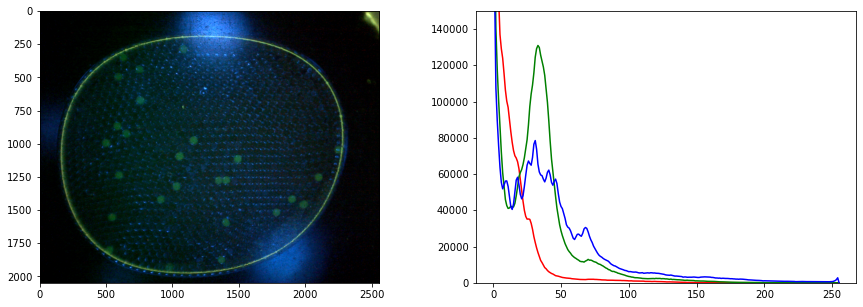

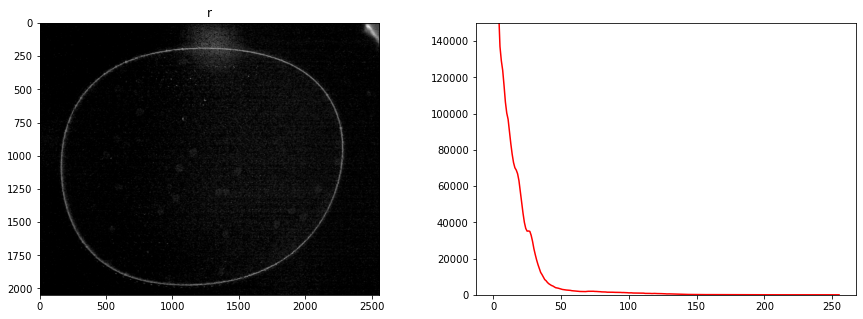

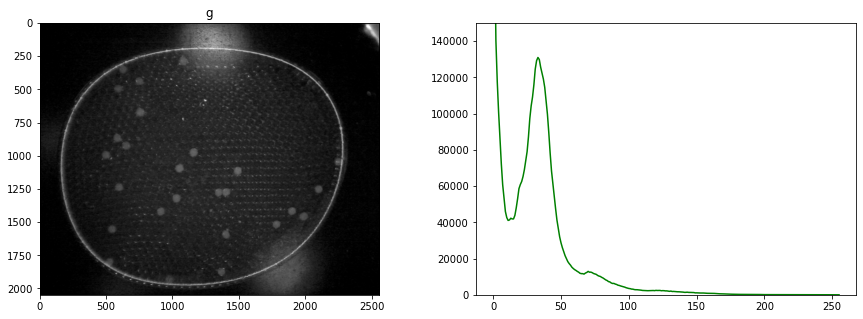

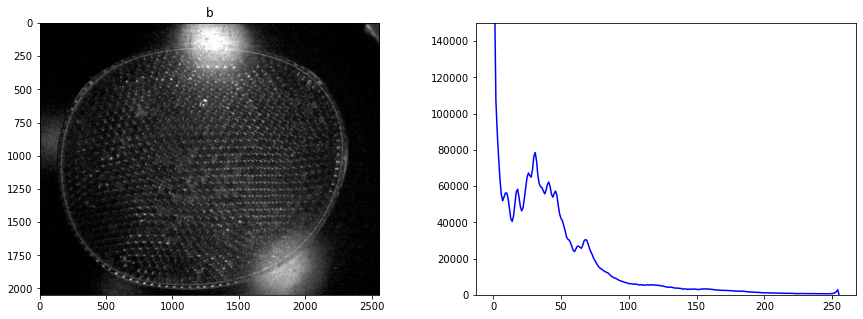

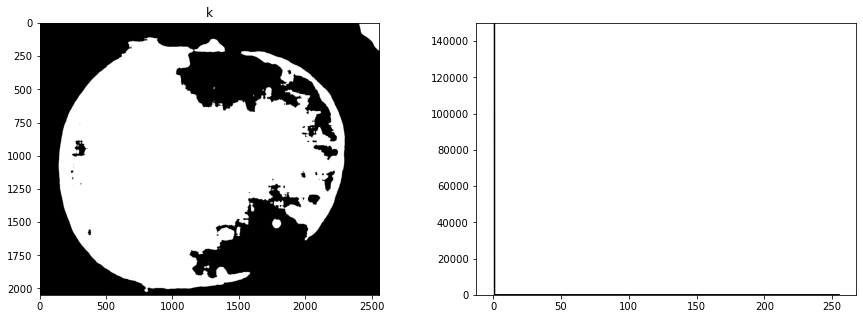

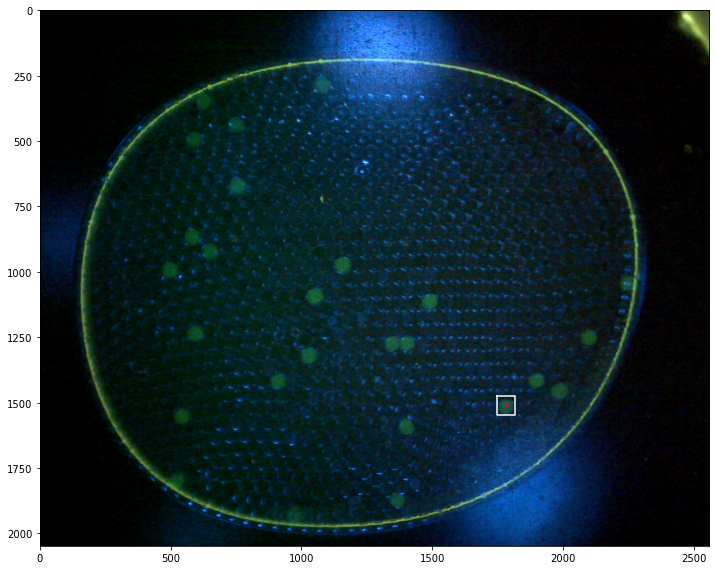

In [106]:
# TESTING

# create labeler instance
labeler = ParticleLabeler()

# read image file
labeler.imread("data/25-miniM.tif")

# display image and histogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
labeler.imshow(ax[0])
labeler.display_histogram(ax[1])
ax[1].set_ylim(0, 150000)

# make composite channel
labeler.composite({'g':1, 'b':-0.53}, 'k')

# threshold
labeler.threshold(src='k', dst='k')

# label
labeler.label(src='k')
print(labeler.particle_count)

# display all channels
for color, channel in labeler.channels.items():
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    channel.imshow(ax[0], color)
    channel.display_histogram(ax[1], color=color)
    ax[1].set_ylim(0, 150000)
    
fix, ax = plt.subplots(1, 1, figsize=(12,10))
labeler.imshow(ax)
for p in labeler.particles:
    if p.size() > 50 and p.size() < 150:
        x, y = p.bounding_box()
        ax.plot(x, y, 'w')
        ax.plot([p.x], [p.y], 'r.', ms=5)

## 10.11.3 Demonstrations

46


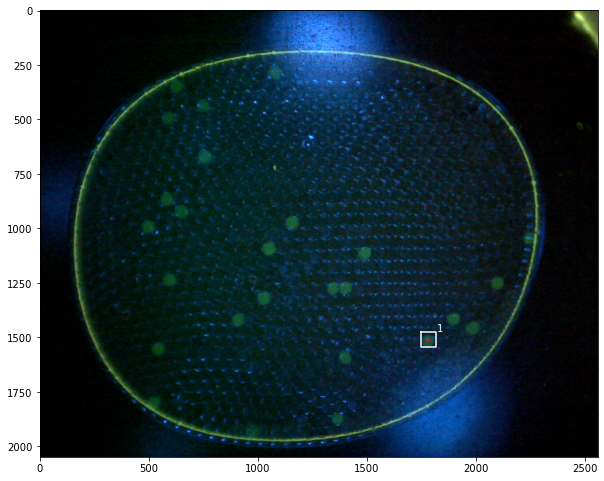

In [107]:
labeler = ParticleLabeler()
labeler.find_particles("data/25-miniM.tif", size=(50, 150))
print(labeler.particle_count)

Text(0.5, 1.0, 'Threshold = 80.0')

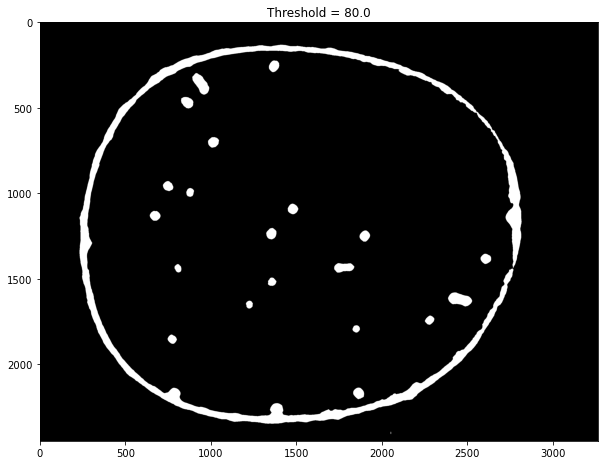

In [113]:
img = labeler.channels['g'].img
fimg = cv.GaussianBlur(img, (71, 71), 0)
fimg = cv.medianBlur(img, 51)
T, timg = cv.threshold(fimg, 80, 255, cv.THRESH_BINARY)
#T, timg = cv.threshold(fimg, 0, 255, cv.THRESH_OTSU)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
#ax.imshow(img, cmap="gray")
#ax.imshow(img, cmap="gray")
ax.imshow(timg, cmap="gray")
ax.set_title(f"Threshold = {T}")
#ax.imshow(edges, cmap="hot", alpha=0.8)

34


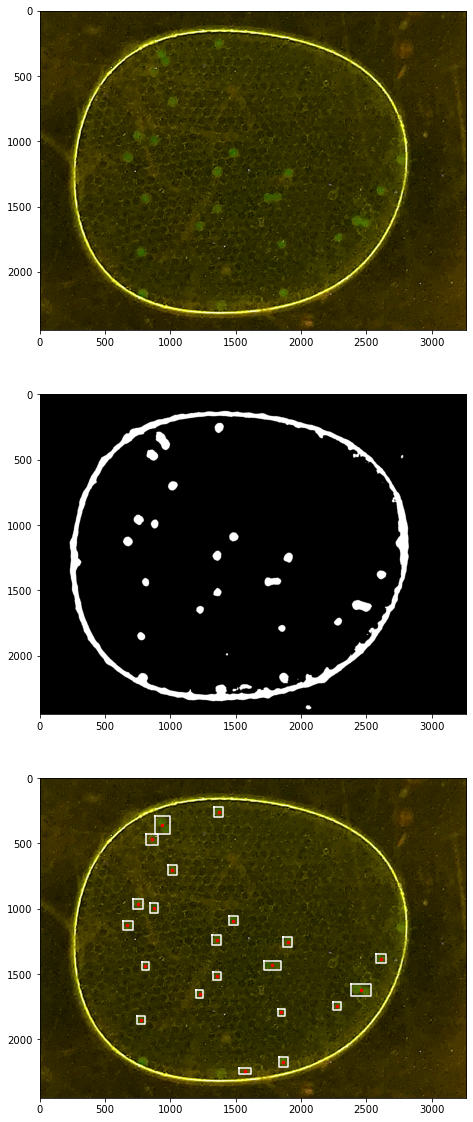

In [120]:
# TESTING

# create labeler instance
labeler = ParticleLabeler()

# read image file
labeler.imread("data/25-camera.jpg")

# make composite channel
labeler.composite({'g':1}, 'k')

# threshold
labeler.threshold(src='k', dst='k', r=41)

# label
labeler.label(src='k')
print(labeler.particle_count)

    
fix, ax = plt.subplots(3, 1, figsize=(12,20))
labeler.imshow(ax[0])
labeler.channels['k'].imshow(ax[1])
labeler.imshow(ax[2])
for p in labeler.particles:
    if p.size() > 50 and p.size() < 150:
        x, y = p.bounding_box()
        ax[2].plot(x, y, 'w')
        ax[2].plot([p.x], [p.y], 'r.', ms=5)

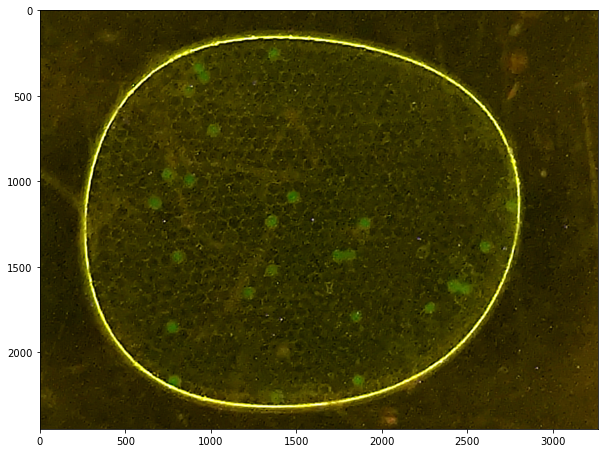

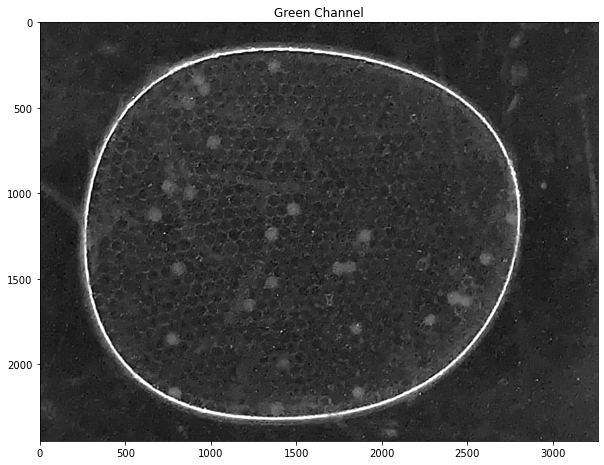

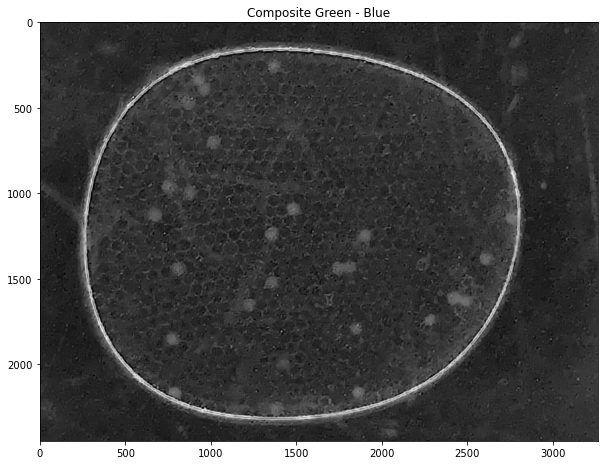

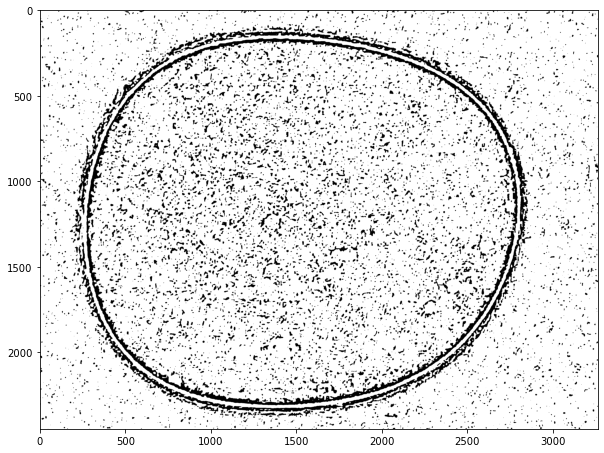

In [108]:
labeler = ParticleLabeler()
labeler.imread("data/25-camera.jpg")
labeler.imshow()
labeler.channels['g'].imshow(title="Green Channel")
labeler.composite({'g':1, 'b':-0.53}, 'k')
labeler.channels['k'].imshow(title="Composite Green - Blue")
labeler.adaptive_threshold(src='g', dst='k2')
labeler.channels['k2'].imshow()

### 10.11.3.1 Thresholding

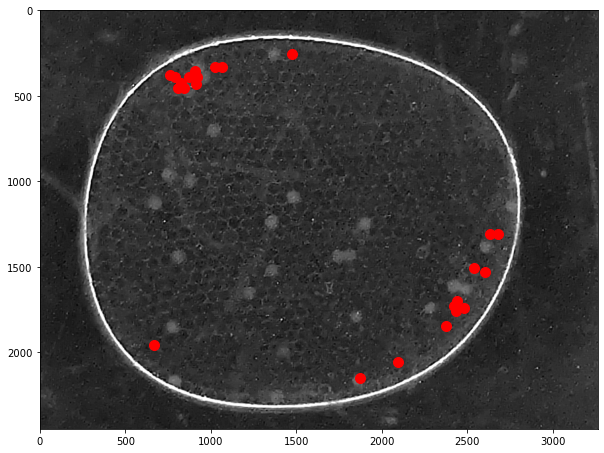

In [110]:
circles = cv.HoughCircles(timg, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          30, 
                          param1=80, 
                          param2=20, 
                          minRadius=50, 
                          maxRadius=200)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.imshow(img, cmap="gray")

for circle in circles[0]:
    x, y, r = circle
    plt.plot([x], [y], 'r.', ms=20)
    

<!--NAVIGATION-->
< [10.10 Computer Vision Case Study: Introduction](https://jckantor.github.io/cbe61622/10.10-Computer-Vision-Introduction.html) | [Contents](toc.html) | [10.12 Computer Vision Case Study: Creating an Application](https://jckantor.github.io/cbe61622/10.12-Computer-Vision-Application.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe61622/blob/master/docs/10.11-Computer-Vision-Development.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe61622/10.11-Computer-Vision-Development.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>